PASO 9: MODELADO MACHINE LEARNING COMPLETO

✓ Imports completados
✓ Random state fijado: 42

SECCIÓN 2: CARGA DE DATASETS

Cargando datasets...

✓ Dataset A cargado: 538 filas × 42 columnas
  Uso: Random Forest, XGBoost, KNN
✓ Dataset B cargado: 538 filas × 19 columnas
  Uso: Regresión Logística

Variable objetivo: 'SOP (S/N)'

✓ Variable objetivo verificada en ambos datasets

Distribución de clases:

  Dataset A:
    Clase 0: 362 (67.3%)
    Clase 1: 176 (32.7%)

  Dataset B:
    Clase 0: 362 (67.3%)
    Clase 1: 176 (32.7%)

Verificación de valores nulos:
  Dataset A: 0 nulos
  Dataset B: 0 nulos
  ✓ No hay valores nulos

SECCIÓN 3: TRAIN/TEST SPLIT ESTRATIFICADO

Configuración: 80% train / 20% test
Random state: 42
Stratified: Sí (preserva distribución de clases)

Dataset A (Árboles):
  Train: 430 muestras
  Test:  108 muestras
  Features: 41

  Distribución train:
    Clase 0: 67.2%
    Clase 1: 32.8%
  Distribución test:
    Clase 0: 67.6%
    Clase 1: 32.4%

Dataset B (Regresión 

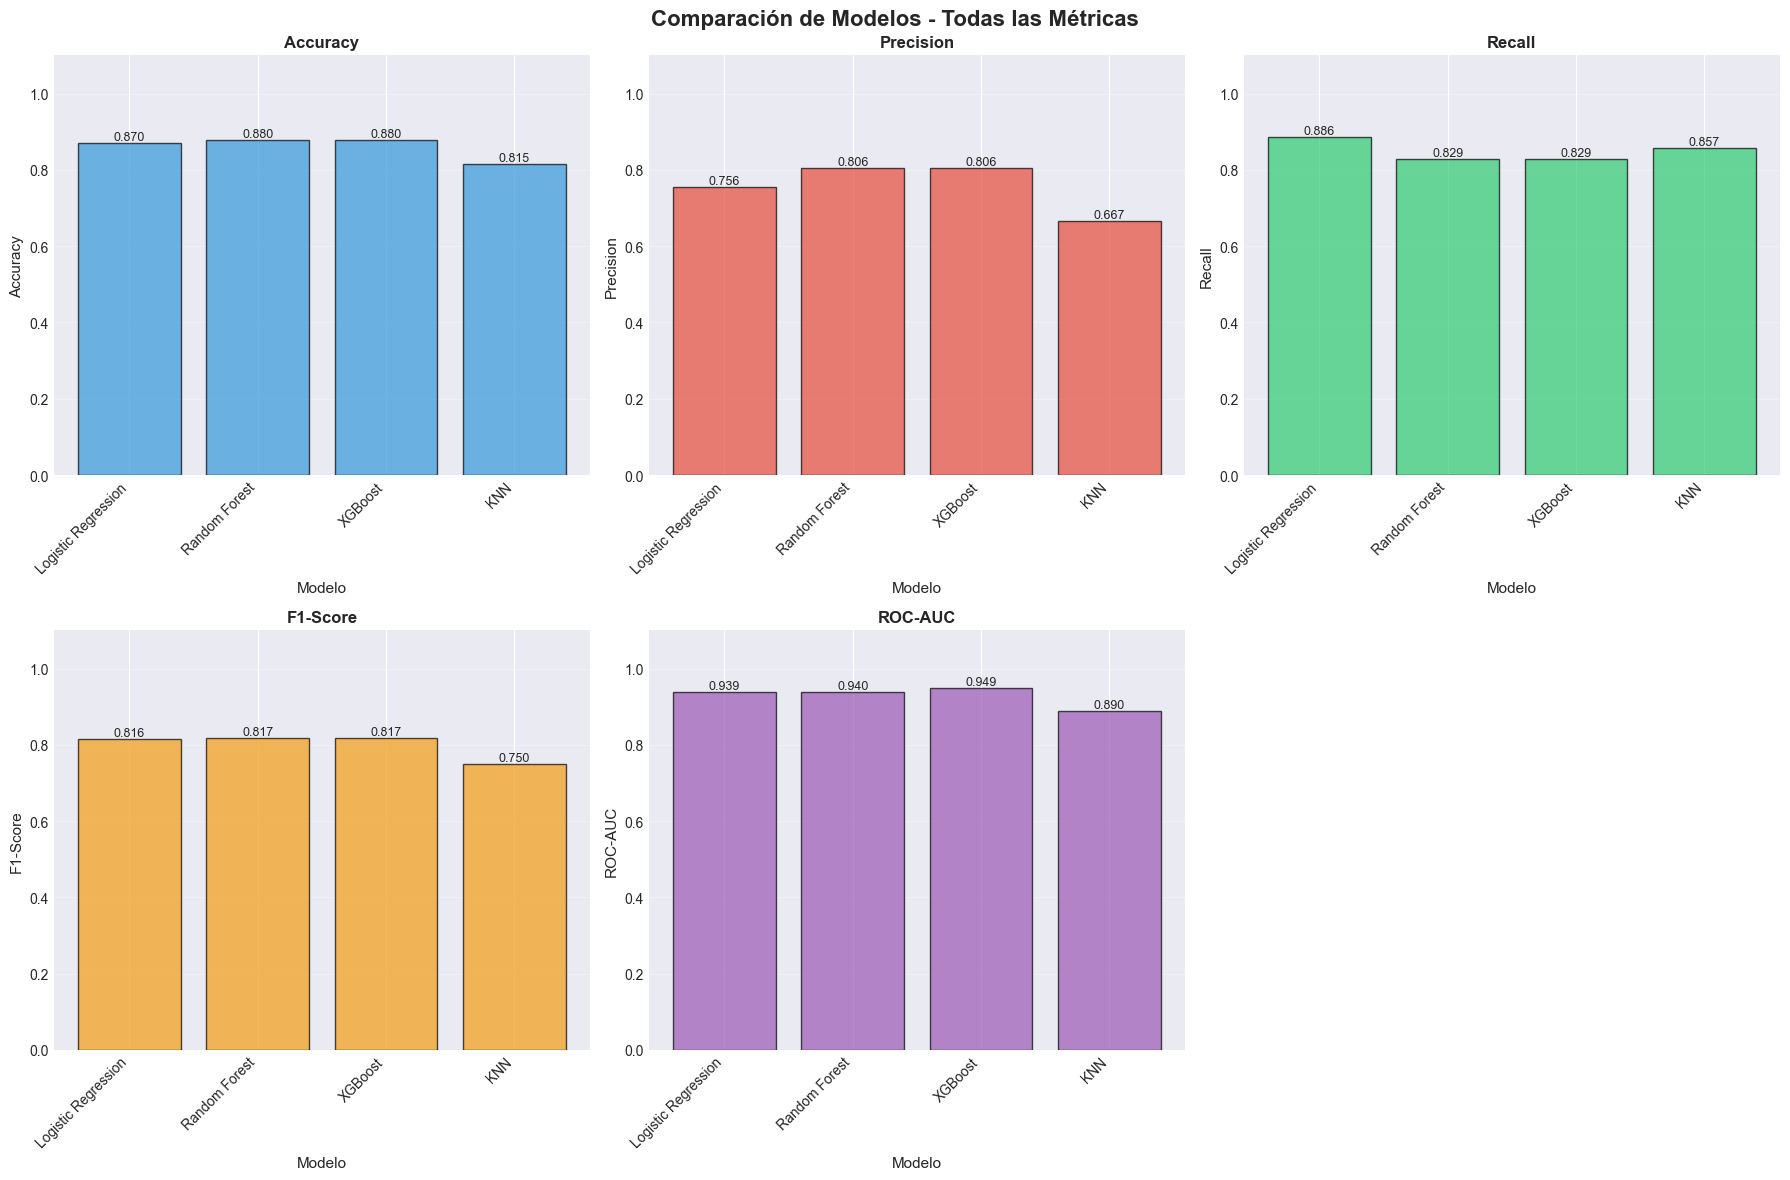

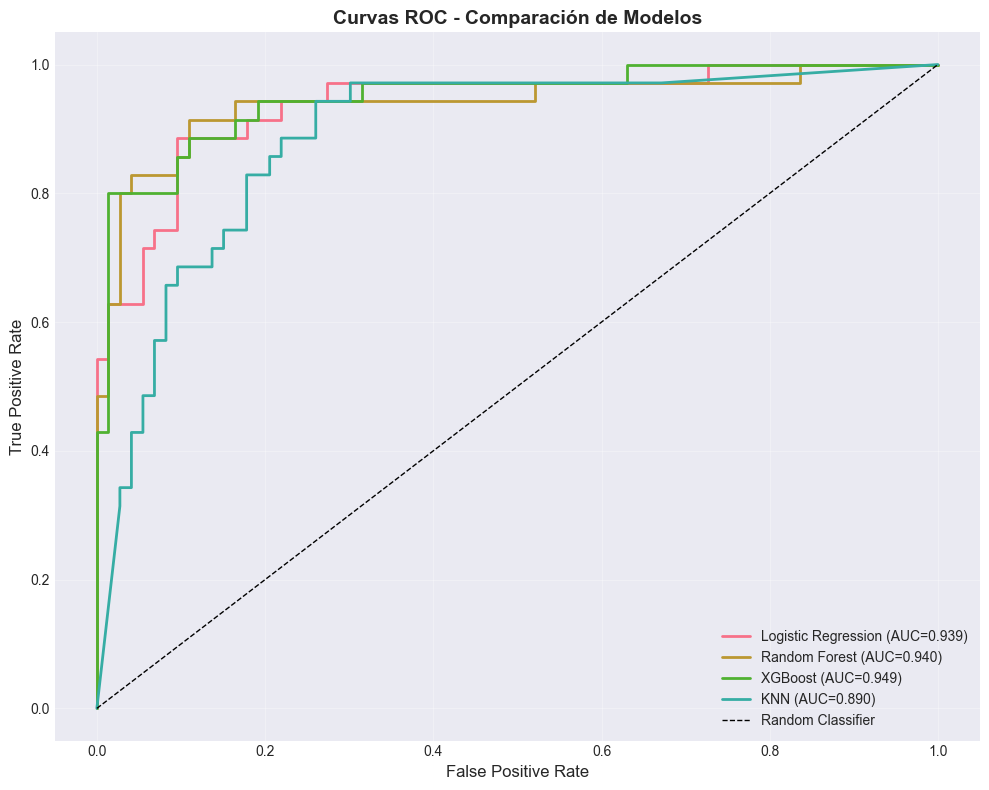

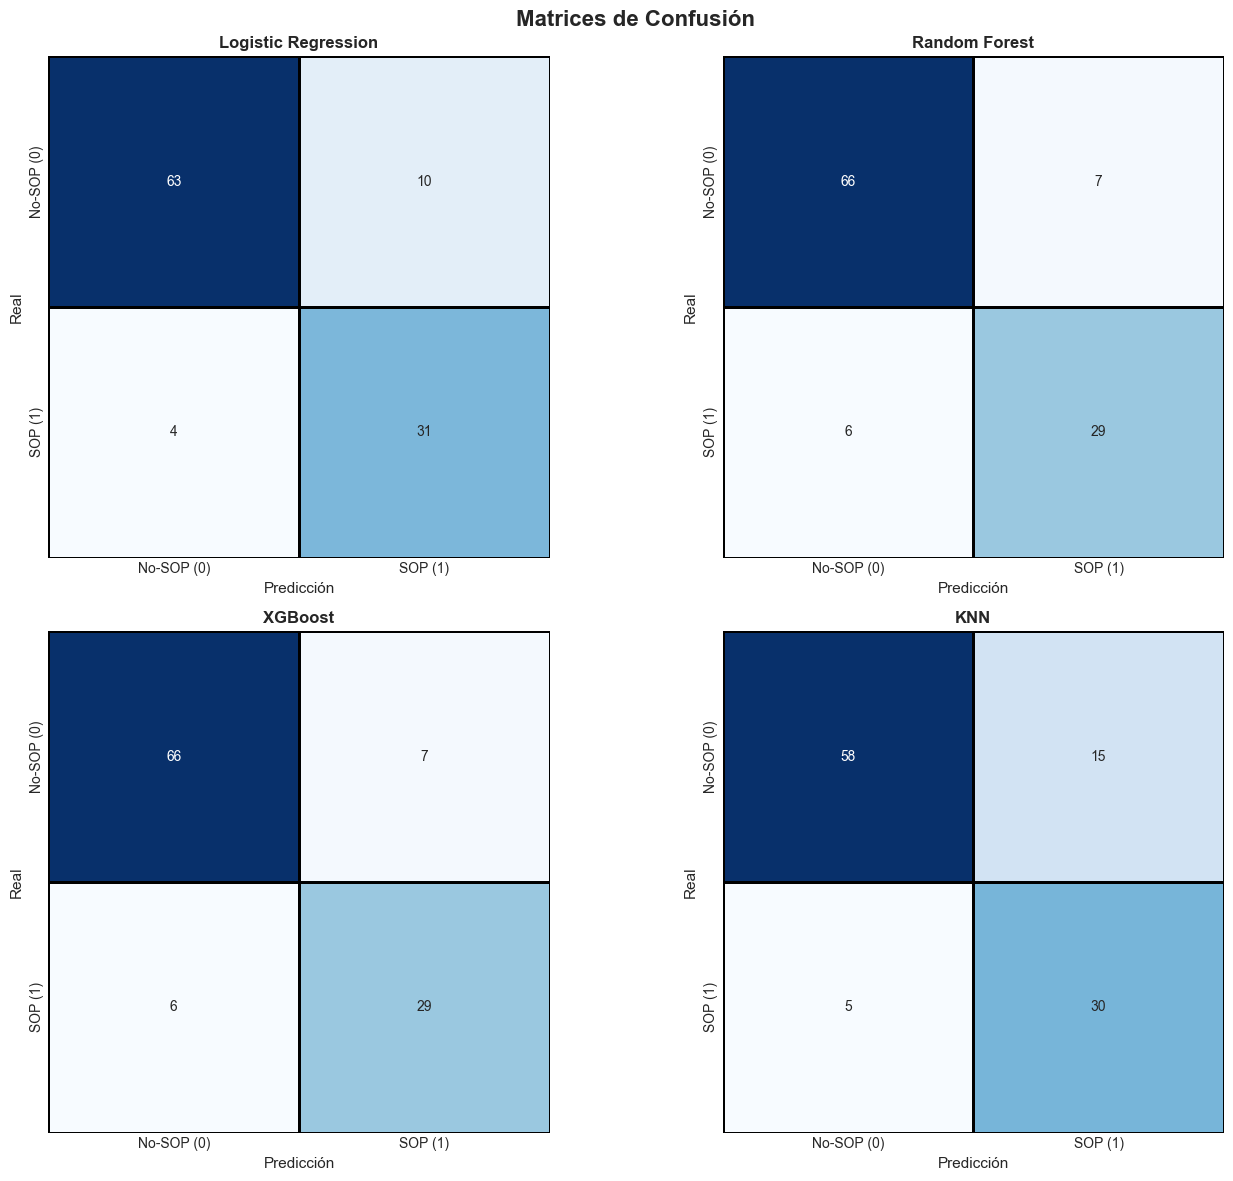

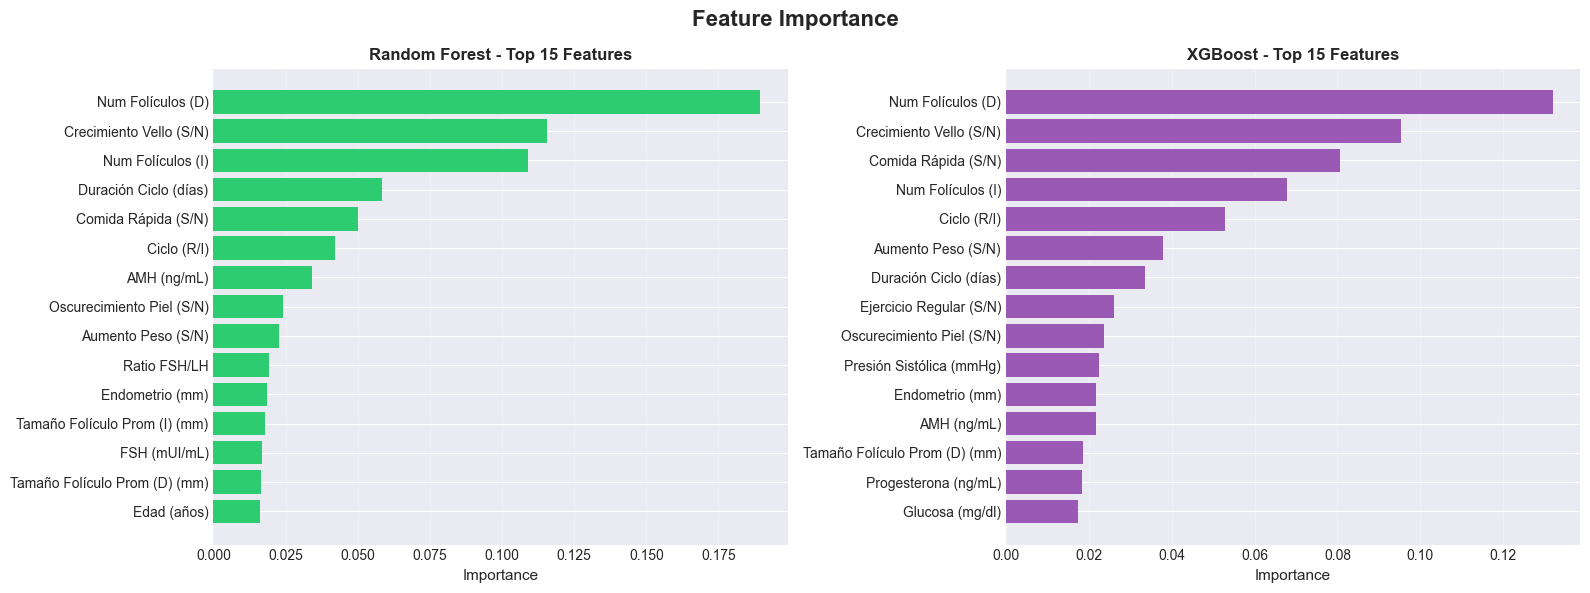

In [2]:
"""
================================================================================
PASO 9: MODELADO MACHINE LEARNING COMPLETO
================================================================================

Proyecto: Predicción de Síndrome de Ovario Poliquístico (SOP)
Institución: Clúster de Ingeniería Biomédica del Estado de Jalisco
Fecha: 1 noviembre 2025
Autor: Usuario (QFB) + Claude (Asistente)

METODOLOGÍA:
- Opción A: COMPLETA (LASSO + RFE + Grid Search + Validación Cruzada)
- Sub-opción A1: Dataset específico por modelo
- Estrategia: 2 datasets según tipo de modelo

DATASETS:
A) PCOS_data_transformado.csv (42 vars)                    → Random Forest, XGBoost, KNN
B) PCOS_data_FINAL_sin_multicolinealidad.csv (19 vars)    → Regresión Logística

MODELOS:
1. Regresión Logística (con LASSO feature selection)
2. Random Forest (con RFE feature selection)
3. XGBoost (con feature importance)
4. KNN (baseline sin selección)

OBJETIVO:
- Comparar performance de modelos
- Identificar mejores predictores
- Obtener modelo óptimo para diagnóstico SOP

CALIDAD:
✓ Código reproducible (random_state fijo)
✓ Sin data leakage (SMOTE solo en train)
✓ Validación cruzada estratificada
✓ Optimización de hiperparámetros
✓ Métricas completas
✓ Documentación exhaustiva

================================================================================

INSTALACIÓN DE DEPENDENCIAS REQUERIDAS:
================================================================================

Si no tienes instaladas las librerías, ejecuta en terminal:

pip install xgboost imbalanced-learn

================================================================================
"""

# =============================================================================
# SECCIÓN 1: IMPORTS Y CONFIGURACIÓN
# =============================================================================

print("="*80)
print("PASO 9: MODELADO MACHINE LEARNING COMPLETO")
print("="*80)
print()

# Configuración de warnings
import warnings
warnings.filterwarnings('ignore')

# Librerías estándar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json

# Scikit-learn - Preprocesamiento
from sklearn.model_selection import (
    train_test_split, 
    StratifiedKFold, 
    GridSearchCV,
    cross_val_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, SelectFromModel

# Scikit-learn - Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# Scikit-learn - Métricas
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
    make_scorer
)

# Balanceo de clases
from imblearn.over_sampling import SMOTE

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Semilla global para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ Imports completados")
print(f"✓ Random state fijado: {RANDOM_STATE}")
print()

# =============================================================================
# SECCIÓN 2: CARGA Y VERIFICACIÓN DE DATOS
# =============================================================================

print("="*80)
print("SECCIÓN 2: CARGA DE DATASETS")
print("="*80)
print()

# RUTAS REALES DEL PROYECTO
PATH_DATASET_A = '../documentos_generados/PCOS_data_transformado.csv'  # 42 variables
PATH_DATASET_B = 'PCOS_data_FINAL_sin_multicolinealidad.csv'  # 19 variables

print("Cargando datasets...")
print()

# Dataset A: Para modelos basados en árboles
try:
    df_trees = pd.read_csv(PATH_DATASET_A)
    print(f"✓ Dataset A cargado: {df_trees.shape[0]} filas × {df_trees.shape[1]} columnas")
    print(f"  Uso: Random Forest, XGBoost, KNN")
except FileNotFoundError:
    print(f"✗ ERROR: No se encontró {PATH_DATASET_A}")
    print("  Por favor, ajusta la ruta en la línea 99")
    raise

# Dataset B: Para regresión logística
try:
    df_logit = pd.read_csv(PATH_DATASET_B)
    print(f"✓ Dataset B cargado: {df_logit.shape[0]} filas × {df_logit.shape[1]} columnas")
    print(f"  Uso: Regresión Logística")
except FileNotFoundError:
    print(f"✗ ERROR: No se encontró {PATH_DATASET_B}")
    print("  Por favor, ajusta la ruta en la línea 100")
    raise

print()

# Verificación de variable objetivo (AJUSTAR SI NECESARIO)
TARGET_COL = 'SOP (S/N)'

print(f"Variable objetivo: '{TARGET_COL}'")
print()

# Verificar que existe en ambos datasets
if TARGET_COL not in df_trees.columns:
    print(f"✗ ERROR: '{TARGET_COL}' no encontrado en Dataset A")
    print(f"  Columnas disponibles: {df_trees.columns.tolist()}")
    raise ValueError("Ajusta TARGET_COL en línea 124")

if TARGET_COL not in df_logit.columns:
    print(f"✗ ERROR: '{TARGET_COL}' no encontrado en Dataset B")
    print(f"  Columnas disponibles: {df_logit.columns.tolist()}")
    raise ValueError("Ajusta TARGET_COL en línea 124")

print("✓ Variable objetivo verificada en ambos datasets")
print()

# Estadísticas de la variable objetivo
print("Distribución de clases:")
for dataset_name, df in [("Dataset A", df_trees), ("Dataset B", df_logit)]:
    print(f"\n  {dataset_name}:")
    dist = df[TARGET_COL].value_counts()
    for clase, count in dist.items():
        pct = count / len(df) * 100
        print(f"    Clase {clase}: {count} ({pct:.1f}%)")

print()

# Verificar que no hay nulos
print("Verificación de valores nulos:")
print(f"  Dataset A: {df_trees.isnull().sum().sum()} nulos")
print(f"  Dataset B: {df_logit.isnull().sum().sum()} nulos")

if df_trees.isnull().sum().sum() > 0 or df_logit.isnull().sum().sum() > 0:
    print("  ⚠️ ADVERTENCIA: Se encontraron valores nulos")
    print("  Se recomienda resolverlos antes de continuar")
else:
    print("  ✓ No hay valores nulos")

print()

# =============================================================================
# SECCIÓN 3: PREPARACIÓN DE DATOS - TRAIN/TEST SPLIT
# =============================================================================

print("="*80)
print("SECCIÓN 3: TRAIN/TEST SPLIT ESTRATIFICADO")
print("="*80)
print()

# Proporción de split
TEST_SIZE = 0.20
print(f"Configuración: {int((1-TEST_SIZE)*100)}% train / {int(TEST_SIZE*100)}% test")
print(f"Random state: {RANDOM_STATE}")
print(f"Stratified: Sí (preserva distribución de clases)")
print()

# ========== DATASET A: Para Random Forest, XGBoost, KNN ==========

print("Dataset A (Árboles):")
X_trees = df_trees.drop(TARGET_COL, axis=1)
y_trees = df_trees[TARGET_COL]

X_train_trees, X_test_trees, y_train_trees, y_test_trees = train_test_split(
    X_trees,
    y_trees,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_trees
)

print(f"  Train: {len(X_train_trees)} muestras")
print(f"  Test:  {len(X_test_trees)} muestras")
print(f"  Features: {X_train_trees.shape[1]}")
print()

# Verificar distribución en train/test
print("  Distribución train:")
train_dist = y_train_trees.value_counts(normalize=True)
for clase, pct in train_dist.items():
    print(f"    Clase {clase}: {pct*100:.1f}%")

print("  Distribución test:")
test_dist = y_test_trees.value_counts(normalize=True)
for clase, pct in test_dist.items():
    print(f"    Clase {clase}: {pct*100:.1f}%")

print()

# ========== DATASET B: Para Regresión Logística ==========

print("Dataset B (Regresión Logística):")
X_logit = df_logit.drop(TARGET_COL, axis=1)
y_logit = df_logit[TARGET_COL]

X_train_logit, X_test_logit, y_train_logit, y_test_logit = train_test_split(
    X_logit,
    y_logit,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_logit
)

print(f"  Train: {len(X_train_logit)} muestras")
print(f"  Test:  {len(X_test_logit)} muestras")
print(f"  Features: {X_train_logit.shape[1]}")
print()

# Verificar distribución
print("  Distribución train:")
train_dist = y_train_logit.value_counts(normalize=True)
for clase, pct in train_dist.items():
    print(f"    Clase {clase}: {pct*100:.1f}%")

print("  Distribución test:")
test_dist = y_test_logit.value_counts(normalize=True)
for clase, pct in test_dist.items():
    print(f"    Clase {clase}: {pct*100:.1f}%")

print()
print("✓ Train/Test split completado para ambos datasets")
print()

# =============================================================================
# SECCIÓN 4: BALANCEO DE CLASES CON SMOTE
# =============================================================================

print("="*80)
print("SECCIÓN 4: BALANCEO DE CLASES CON SMOTE")
print("="*80)
print()

print("IMPORTANTE: SMOTE se aplica SOLO en train set")
print("           Test set mantiene distribución original")
print()

# ========== SMOTE para Dataset A (Árboles) ==========

print("Aplicando SMOTE a Dataset A (train)...")

smote_trees = SMOTE(
    sampling_strategy='auto',  # Balance 1:1
    random_state=RANDOM_STATE,
    k_neighbors=5
)

X_train_trees_balanced, y_train_trees_balanced = smote_trees.fit_resample(
    X_train_trees, 
    y_train_trees
)

print(f"  Antes SMOTE:  {len(X_train_trees)} muestras")
print(f"  Después SMOTE: {len(X_train_trees_balanced)} muestras")
print(f"  Muestras sintéticas creadas: {len(X_train_trees_balanced) - len(X_train_trees)}")
print()

print("  Distribución balanceada:")
balanced_dist = y_train_trees_balanced.value_counts(normalize=True)
for clase, pct in balanced_dist.items():
    print(f"    Clase {clase}: {pct*100:.1f}%")

print()

# ========== SMOTE para Dataset B (Regresión Logística) ==========

print("Aplicando SMOTE a Dataset B (train)...")

smote_logit = SMOTE(
    sampling_strategy='auto',
    random_state=RANDOM_STATE,
    k_neighbors=5
)

X_train_logit_balanced, y_train_logit_balanced = smote_logit.fit_resample(
    X_train_logit,
    y_train_logit
)

print(f"  Antes SMOTE:  {len(X_train_logit)} muestras")
print(f"  Después SMOTE: {len(X_train_logit_balanced)} muestras")
print(f"  Muestras sintéticas creadas: {len(X_train_logit_balanced) - len(X_train_logit)}")
print()

print("  Distribución balanceada:")
balanced_dist = y_train_logit_balanced.value_counts(normalize=True)
for clase, pct in balanced_dist.items():
    print(f"    Clase {clase}: {pct*100:.1f}%")

print()
print("✓ SMOTE aplicado exitosamente a ambos datasets")
print()

# =============================================================================
# SECCIÓN 5: ESCALAMIENTO DE DATOS
# =============================================================================

print("="*80)
print("SECCIÓN 5: ESCALAMIENTO (STANDARDIZATION)")
print("="*80)
print()

print("Escalamiento necesario para:")
print("  - Regresión Logística (sensible a escala)")
print("  - KNN (basado en distancias)")
print()
print("NO necesario para:")
print("  - Random Forest (basado en árboles)")
print("  - XGBoost (basado en árboles)")
print()

# ========== Escalamiento para Regresión Logística ==========

print("Escalando Dataset B (Regresión Logística)...")

scaler_logit = StandardScaler()

# Fit en train, transform en train y test
X_train_logit_scaled = scaler_logit.fit_transform(X_train_logit_balanced)
X_test_logit_scaled = scaler_logit.transform(X_test_logit)

# Convertir de nuevo a DataFrame (preservar nombres de columnas)
X_train_logit_scaled = pd.DataFrame(
    X_train_logit_scaled,
    columns=X_train_logit.columns
)
X_test_logit_scaled = pd.DataFrame(
    X_test_logit_scaled,
    columns=X_test_logit.columns
)

print(f"  ✓ Train escalado: {X_train_logit_scaled.shape}")
print(f"  ✓ Test escalado:  {X_test_logit_scaled.shape}")
print()

# ========== Escalamiento para KNN ==========

print("Escalando Dataset A para KNN...")

scaler_knn = StandardScaler()

X_train_trees_scaled = scaler_knn.fit_transform(X_train_trees_balanced)
X_test_trees_scaled = scaler_knn.transform(X_test_trees)

X_train_trees_scaled = pd.DataFrame(
    X_train_trees_scaled,
    columns=X_train_trees.columns
)
X_test_trees_scaled = pd.DataFrame(
    X_test_trees_scaled,
    columns=X_test_trees.columns
)

print(f"  ✓ Train escalado: {X_train_trees_scaled.shape}")
print(f"  ✓ Test escalado:  {X_test_trees_scaled.shape}")
print()

print("✓ Escalamiento completado")
print()

# =============================================================================
# SECCIÓN 6: SELECCIÓN DE FEATURES - LASSO (REGRESIÓN LOGÍSTICA)
# =============================================================================

print("="*80)
print("SECCIÓN 6A: SELECCIÓN DE FEATURES - LASSO")
print("="*80)
print()

print("Método: LASSO (L1 Regularization)")
print("Modelo: Regresión Logística")
print("Dataset: B (19 variables)")
print()

print("LASSO penaliza coeficientes llevándolos a 0")
print("Variables con coef=0 se eliminan automáticamente")
print()

# Probar diferentes valores de C (inverso de regularización)
# C pequeño = más regularización = menos features
# C grande = menos regularización = más features

C_values = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0]

lasso_results = []

print("Probando diferentes valores de regularización (C)...")
print()

for C in C_values:
    # Modelo LASSO
    lasso = LogisticRegression(
        penalty='l1',
        C=C,
        solver='liblinear',
        random_state=RANDOM_STATE,
        max_iter=1000
    )
    
    # Entrenar
    lasso.fit(X_train_logit_scaled, y_train_logit_balanced)
    
    # Obtener coeficientes no-cero
    coef = lasso.coef_[0]
    features_selected = (coef != 0).sum()
    
    # Accuracy en validación cruzada
    cv_score = cross_val_score(
        lasso, 
        X_train_logit_scaled, 
        y_train_logit_balanced,
        cv=5,
        scoring='accuracy'
    ).mean()
    
    lasso_results.append({
        'C': C,
        'n_features': features_selected,
        'cv_accuracy': cv_score
    })
    
    print(f"  C={C:6.3f}: {features_selected:2d} features, CV Accuracy={cv_score:.4f}")

print()

# Convertir a DataFrame
lasso_results_df = pd.DataFrame(lasso_results)

# Encontrar mejor C (máximo CV accuracy)
best_idx = lasso_results_df['cv_accuracy'].idxmax()
best_C = lasso_results_df.loc[best_idx, 'C']
best_n_features = lasso_results_df.loc[best_idx, 'n_features']
best_cv_acc = lasso_results_df.loc[best_idx, 'cv_accuracy']

print(f"✓ Mejor C: {best_C}")
print(f"✓ Features seleccionadas: {best_n_features}")
print(f"✓ CV Accuracy: {best_cv_acc:.4f}")
print()

# Entrenar modelo final con mejor C
lasso_final = LogisticRegression(
    penalty='l1',
    C=best_C,
    solver='liblinear',
    random_state=RANDOM_STATE,
    max_iter=1000
)

lasso_final.fit(X_train_logit_scaled, y_train_logit_balanced)

# Obtener features seleccionadas
coef = lasso_final.coef_[0]
selected_features_lasso = X_train_logit_scaled.columns[coef != 0].tolist()

print("Features seleccionadas por LASSO:")
for i, feat in enumerate(selected_features_lasso, 1):
    coef_val = coef[X_train_logit_scaled.columns.get_loc(feat)]
    print(f"  {i:2d}. {feat:30s} (coef={coef_val:7.4f})")

print()

# Guardar resultados
lasso_results_df.to_csv('lasso_feature_selection_results.csv', index=False)
print("✓ Resultados guardados: lasso_feature_selection_results.csv")
print()

# =============================================================================
# SECCIÓN 6B: SELECCIÓN DE FEATURES - RFE (RANDOM FOREST)
# =============================================================================

print("="*80)
print("SECCIÓN 6B: SELECCIÓN DE FEATURES - RFE")
print("="*80)
print()

print("Método: Recursive Feature Elimination (RFE)")
print("Modelo: Random Forest")
print("Dataset: A (42 variables)")
print()

print("RFE elimina recursivamente la variable menos importante")
print("hasta alcanzar el número deseado de features")
print()

# Probar diferentes números de features
n_features_to_test = [10, 15, 20, 25, 30, 35, 40]

rfe_results = []

print("Probando diferentes números de features...")
print()

for n_features in n_features_to_test:
    # Estimador base
    rf_estimator = RandomForestClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    # RFE
    rfe = RFE(
        estimator=rf_estimator,
        n_features_to_select=n_features,
        step=1
    )
    
    # Fit
    rfe.fit(X_train_trees_balanced, y_train_trees_balanced)
    
    # Transformar datos
    X_train_rfe = rfe.transform(X_train_trees_balanced)
    
    # Accuracy en validación cruzada
    cv_score = cross_val_score(
        rf_estimator,
        X_train_rfe,
        y_train_trees_balanced,
        cv=5,
        scoring='accuracy'
    ).mean()
    
    rfe_results.append({
        'n_features': n_features,
        'cv_accuracy': cv_score
    })
    
    print(f"  {n_features:2d} features: CV Accuracy={cv_score:.4f}")

print()

# Convertir a DataFrame
rfe_results_df = pd.DataFrame(rfe_results)

# Encontrar mejor número de features
best_idx = rfe_results_df['cv_accuracy'].idxmax()
best_n_features_rf = rfe_results_df.loc[best_idx, 'n_features']
best_cv_acc_rf = rfe_results_df.loc[best_idx, 'cv_accuracy']

print(f"✓ Mejor número de features: {best_n_features_rf}")
print(f"✓ CV Accuracy: {best_cv_acc_rf:.4f}")
print()

# Entrenar RFE final
rf_estimator_final = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rfe_final = RFE(
    estimator=rf_estimator_final,
    n_features_to_select=best_n_features_rf,
    step=1
)

rfe_final.fit(X_train_trees_balanced, y_train_trees_balanced)

# Obtener features seleccionadas
selected_features_rfe = X_train_trees_balanced.columns[rfe_final.support_].tolist()

print(f"Features seleccionadas por RFE ({len(selected_features_rfe)}):")
for i, feat in enumerate(selected_features_rfe, 1):
    ranking = rfe_final.ranking_[X_train_trees_balanced.columns.get_loc(feat)]
    print(f"  {i:2d}. {feat:30s} (ranking={ranking})")

print()

# Guardar resultados
rfe_results_df.to_csv('rfe_feature_selection_results.csv', index=False)
print("✓ Resultados guardados: rfe_feature_selection_results.csv")
print()

# =============================================================================
# SECCIÓN 7: CONFIGURACIÓN DE VALIDACIÓN CRUZADA
# =============================================================================

print("="*80)
print("SECCIÓN 7: CONFIGURACIÓN DE VALIDACIÓN CRUZADA")
print("="*80)
print()

# Configuración de CV
N_FOLDS = 5

cv_strategy = StratifiedKFold(
    n_splits=N_FOLDS,
    shuffle=True,
    random_state=RANDOM_STATE
)

print(f"Estrategia: StratifiedKFold")
print(f"Número de folds: {N_FOLDS}")
print(f"Shuffle: Sí")
print(f"Random state: {RANDOM_STATE}")
print()

print("StratifiedKFold mantiene la proporción de clases en cada fold")
print("Esto es crítico para datasets desbalanceados")
print()

print("✓ Validación cruzada configurada")
print()

# =============================================================================
# SECCIÓN 8: GRID SEARCH - OPTIMIZACIÓN DE HIPERPARÁMETROS
# =============================================================================

print("="*80)
print("SECCIÓN 8: GRID SEARCH - OPTIMIZACIÓN DE HIPERPARÁMETROS")
print("="*80)
print()

print("Se buscarán los mejores hiperparámetros para cada modelo")
print("usando Grid Search con validación cruzada")
print()

# Diccionario para guardar mejores modelos
best_models = {}
grid_search_results = {}

# ========== 8.1: REGRESIÓN LOGÍSTICA ==========

print("-" * 80)
print("8.1: REGRESIÓN LOGÍSTICA")
print("-" * 80)
print()

print("Hiperparámetros a optimizar:")
print("  - C (regularización)")
print("  - penalty (L1 o L2)")
print()

# Grid de hiperparámetros
param_grid_logit = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],  # L2 porque ya hicimos feature selection con L1
    'solver': ['lbfgs'],
    'max_iter': [1000]
}

# Usar features seleccionadas por LASSO
X_train_logit_selected = X_train_logit_scaled[selected_features_lasso]
X_test_logit_selected = X_test_logit_scaled[selected_features_lasso]

print(f"Features usadas: {len(selected_features_lasso)} (seleccionadas por LASSO)")
print()

# Grid Search
print("Ejecutando Grid Search... (esto puede tardar ~2 min)")

grid_logit = GridSearchCV(
    estimator=LogisticRegression(random_state=RANDOM_STATE),
    param_grid=param_grid_logit,
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_logit.fit(X_train_logit_selected, y_train_logit_balanced)

print()
print(f"✓ Grid Search completado")
print(f"✓ Mejores parámetros: {grid_logit.best_params_}")
print(f"✓ Mejor CV score: {grid_logit.best_score_:.4f}")
print()

# Guardar mejor modelo
best_models['Logistic Regression'] = grid_logit.best_estimator_
grid_search_results['Logistic Regression'] = {
    'best_params': grid_logit.best_params_,
    'best_score': grid_logit.best_score_,
    'n_features': len(selected_features_lasso)
}

# ========== 8.2: RANDOM FOREST ==========

print("-" * 80)
print("8.2: RANDOM FOREST")
print("-" * 80)
print()

print("Hiperparámetros a optimizar:")
print("  - n_estimators (número de árboles)")
print("  - max_depth (profundidad máxima)")
print("  - min_samples_split")
print("  - min_samples_leaf")
print()

# Grid de hiperparámetros
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'random_state': [RANDOM_STATE]
}

# Usar features seleccionadas por RFE
X_train_rf_selected = rfe_final.transform(X_train_trees_balanced)
X_test_rf_selected = rfe_final.transform(X_test_trees)

print(f"Features usadas: {len(selected_features_rfe)} (seleccionadas por RFE)")
print()

# Grid Search (con menos combinaciones para velocidad)
print("Ejecutando Grid Search... (esto puede tardar ~5 min)")
print("Nota: Se usa un subset del grid por tiempo de cómputo")

# Grid reducido para velocidad
param_grid_rf_reduced = {
    'n_estimators': [200],
    'max_depth': [10, 15, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'random_state': [RANDOM_STATE]
}

grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid_rf_reduced,
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train_rf_selected, y_train_trees_balanced)

print()
print(f"✓ Grid Search completado")
print(f"✓ Mejores parámetros: {grid_rf.best_params_}")
print(f"✓ Mejor CV score: {grid_rf.best_score_:.4f}")
print()

# Guardar mejor modelo
best_models['Random Forest'] = grid_rf.best_estimator_
grid_search_results['Random Forest'] = {
    'best_params': grid_rf.best_params_,
    'best_score': grid_rf.best_score_,
    'n_features': len(selected_features_rfe)
}

# ========== 8.3: XGBOOST ==========

print("-" * 80)
print("8.3: XGBOOST")
print("-" * 80)
print()

print("Hiperparámetros a optimizar:")
print("  - learning_rate")
print("  - n_estimators")
print("  - max_depth")
print("  - subsample")
print()

# Grid de hiperparámetros
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'random_state': [RANDOM_STATE]
}

# Usar todas las features (XGBoost maneja bien muchas variables)
print(f"Features usadas: {X_train_trees_balanced.shape[1]} (todas)")
print()

print("Ejecutando Grid Search... (esto puede tardar ~3 min)")

grid_xgb = GridSearchCV(
    estimator=xgb.XGBClassifier(eval_metric='logloss'),
    param_grid=param_grid_xgb,
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train_trees_balanced, y_train_trees_balanced)

print()
print(f"✓ Grid Search completado")
print(f"✓ Mejores parámetros: {grid_xgb.best_params_}")
print(f"✓ Mejor CV score: {grid_xgb.best_score_:.4f}")
print()

# Guardar mejor modelo
best_models['XGBoost'] = grid_xgb.best_estimator_
grid_search_results['XGBoost'] = {
    'best_params': grid_xgb.best_params_,
    'best_score': grid_xgb.best_score_,
    'n_features': X_train_trees_balanced.shape[1]
}

# ========== 8.4: KNN ==========

print("-" * 80)
print("8.4: K-NEAREST NEIGHBORS (KNN)")
print("-" * 80)
print()

print("Hiperparámetros a optimizar:")
print("  - n_neighbors")
print("  - weights")
print("  - metric")
print()

# Grid de hiperparámetros
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

print(f"Features usadas: {X_train_trees_scaled.shape[1]} (todas, escaladas)")
print()

print("Ejecutando Grid Search... (esto puede tardar ~1 min)")

grid_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid_knn,
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_knn.fit(X_train_trees_scaled, y_train_trees_balanced)

print()
print(f"✓ Grid Search completado")
print(f"✓ Mejores parámetros: {grid_knn.best_params_}")
print(f"✓ Mejor CV score: {grid_knn.best_score_:.4f}")
print()

# Guardar mejor modelo
best_models['KNN'] = grid_knn.best_estimator_
grid_search_results['KNN'] = {
    'best_params': grid_knn.best_params_,
    'best_score': grid_knn.best_score_,
    'n_features': X_train_trees_scaled.shape[1]
}

# Guardar resultados de Grid Search
with open('grid_search_results.json', 'w') as f:
    # Convertir a formato serializable
    results_serializable = {}
    for model_name, results in grid_search_results.items():
        results_serializable[model_name] = {
            'best_params': {k: str(v) for k, v in results['best_params'].items()},
            'best_score': float(results['best_score']),
            'n_features': int(results['n_features'])
        }
    json.dump(results_serializable, f, indent=2)

print("✓ Resultados de Grid Search guardados: grid_search_results.json")
print()

# =============================================================================
# SECCIÓN 9: EVALUACIÓN EN TEST SET
# =============================================================================

print("="*80)
print("SECCIÓN 9: EVALUACIÓN EN TEST SET")
print("="*80)
print()

print("Los modelos optimizados se evalúan en el test set")
print("(datos NO vistos durante entrenamiento)")
print()

# Diccionario para guardar resultados
test_results = {}

# ========== 9.1: REGRESIÓN LOGÍSTICA ==========

print("-" * 80)
print("9.1: REGRESIÓN LOGÍSTICA")
print("-" * 80)
print()

model_logit = best_models['Logistic Regression']
y_pred_logit = model_logit.predict(X_test_logit_selected)
y_pred_proba_logit = model_logit.predict_proba(X_test_logit_selected)[:, 1]

# Métricas
accuracy_logit = accuracy_score(y_test_logit, y_pred_logit)
precision_logit = precision_score(y_test_logit, y_pred_logit)
recall_logit = recall_score(y_test_logit, y_pred_logit)
f1_logit = f1_score(y_test_logit, y_pred_logit)
auc_logit = roc_auc_score(y_test_logit, y_pred_proba_logit)

print(f"Accuracy:  {accuracy_logit:.4f}")
print(f"Precision: {precision_logit:.4f}")
print(f"Recall:    {recall_logit:.4f}")
print(f"F1-Score:  {f1_logit:.4f}")
print(f"ROC-AUC:   {auc_logit:.4f}")
print()

test_results['Logistic Regression'] = {
    'accuracy': accuracy_logit,
    'precision': precision_logit,
    'recall': recall_logit,
    'f1': f1_logit,
    'auc': auc_logit,
    'y_pred': y_pred_logit,
    'y_pred_proba': y_pred_proba_logit
}

# ========== 9.2: RANDOM FOREST ==========

print("-" * 80)
print("9.2: RANDOM FOREST")
print("-" * 80)
print()

model_rf = best_models['Random Forest']
y_pred_rf = model_rf.predict(X_test_rf_selected)
y_pred_proba_rf = model_rf.predict_proba(X_test_rf_selected)[:, 1]

accuracy_rf = accuracy_score(y_test_trees, y_pred_rf)
precision_rf = precision_score(y_test_trees, y_pred_rf)
recall_rf = recall_score(y_test_trees, y_pred_rf)
f1_rf = f1_score(y_test_trees, y_pred_rf)
auc_rf = roc_auc_score(y_test_trees, y_pred_proba_rf)

print(f"Accuracy:  {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall:    {recall_rf:.4f}")
print(f"F1-Score:  {f1_rf:.4f}")
print(f"ROC-AUC:   {auc_rf:.4f}")
print()

test_results['Random Forest'] = {
    'accuracy': accuracy_rf,
    'precision': precision_rf,
    'recall': recall_rf,
    'f1': f1_rf,
    'auc': auc_rf,
    'y_pred': y_pred_rf,
    'y_pred_proba': y_pred_proba_rf
}

# ========== 9.3: XGBOOST ==========

print("-" * 80)
print("9.3: XGBOOST")
print("-" * 80)
print()

model_xgb = best_models['XGBoost']
y_pred_xgb = model_xgb.predict(X_test_trees)
y_pred_proba_xgb = model_xgb.predict_proba(X_test_trees)[:, 1]

accuracy_xgb = accuracy_score(y_test_trees, y_pred_xgb)
precision_xgb = precision_score(y_test_trees, y_pred_xgb)
recall_xgb = recall_score(y_test_trees, y_pred_xgb)
f1_xgb = f1_score(y_test_trees, y_pred_xgb)
auc_xgb = roc_auc_score(y_test_trees, y_pred_proba_xgb)

print(f"Accuracy:  {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall:    {recall_xgb:.4f}")
print(f"F1-Score:  {f1_xgb:.4f}")
print(f"ROC-AUC:   {auc_xgb:.4f}")
print()

test_results['XGBoost'] = {
    'accuracy': accuracy_xgb,
    'precision': precision_xgb,
    'recall': recall_xgb,
    'f1': f1_xgb,
    'auc': auc_xgb,
    'y_pred': y_pred_xgb,
    'y_pred_proba': y_pred_proba_xgb
}

# ========== 9.4: KNN ==========

print("-" * 80)
print("9.4: K-NEAREST NEIGHBORS")
print("-" * 80)
print()

model_knn = best_models['KNN']
y_pred_knn = model_knn.predict(X_test_trees_scaled)
y_pred_proba_knn = model_knn.predict_proba(X_test_trees_scaled)[:, 1]

accuracy_knn = accuracy_score(y_test_trees, y_pred_knn)
precision_knn = precision_score(y_test_trees, y_pred_knn)
recall_knn = recall_score(y_test_trees, y_pred_knn)
f1_knn = f1_score(y_test_trees, y_pred_knn)
auc_knn = roc_auc_score(y_test_trees, y_pred_proba_knn)

print(f"Accuracy:  {accuracy_knn:.4f}")
print(f"Precision: {precision_knn:.4f}")
print(f"Recall:    {recall_knn:.4f}")
print(f"F1-Score:  {f1_knn:.4f}")
print(f"ROC-AUC:   {auc_knn:.4f}")
print()

test_results['KNN'] = {
    'accuracy': accuracy_knn,
    'precision': precision_knn,
    'recall': recall_knn,
    'f1': f1_knn,
    'auc': auc_knn,
    'y_pred': y_pred_knn,
    'y_pred_proba': y_pred_proba_knn
}

# =============================================================================
# SECCIÓN 10: COMPARACIÓN DE MODELOS
# =============================================================================

print("="*80)
print("SECCIÓN 10: COMPARACIÓN DE MODELOS")
print("="*80)
print()

# Crear DataFrame de comparación
comparison_df = pd.DataFrame({
    'Model': list(test_results.keys()),
    'Accuracy': [results['accuracy'] for results in test_results.values()],
    'Precision': [results['precision'] for results in test_results.values()],
    'Recall': [results['recall'] for results in test_results.values()],
    'F1-Score': [results['f1'] for results in test_results.values()],
    'ROC-AUC': [results['auc'] for results in test_results.values()]
})

print("TABLA COMPARATIVA DE PERFORMANCE:")
print()
print(comparison_df.to_string(index=False))
print()

# Identificar mejor modelo
best_model_name = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']
best_f1 = comparison_df['F1-Score'].max()

print(f"✓ MEJOR MODELO (según F1-Score): {best_model_name} (F1={best_f1:.4f})")
print()

# Guardar tabla
comparison_df.to_csv('model_comparison_results.csv', index=False)
print("✓ Tabla guardada: model_comparison_results.csv")
print()

# =============================================================================
# SECCIÓN 11: VISUALIZACIONES
# =============================================================================

print("="*80)
print("SECCIÓN 11: GENERANDO VISUALIZACIONES")
print("="*80)
print()

# ========== 11.1: Gráfico de Barras - Comparación de Métricas ==========

print("Generando gráfico de comparación de métricas...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comparación de Modelos - Todas las Métricas', fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

for idx, metric in enumerate(metrics):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    x_pos = np.arange(len(comparison_df))
    values = comparison_df[metric]
    
    bars = ax.bar(x_pos, values, color=colors[idx], alpha=0.7, edgecolor='black')
    ax.set_xlabel('Modelo', fontsize=11)
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'{metric}', fontsize=12, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
    ax.set_ylim([0, 1.1])
    ax.grid(axis='y', alpha=0.3)
    
    # Añadir valores encima de las barras
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

# Eliminar subplot vacío
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.savefig('model_comparison_metrics.png', dpi=300, bbox_inches='tight')
print("✓ Guardado: model_comparison_metrics.png")
print()

# ========== 11.2: Curvas ROC ==========

print("Generando curvas ROC...")

plt.figure(figsize=(10, 8))

for model_name, results in test_results.items():
    # Determinar el y_test correcto
    if model_name == 'Logistic Regression':
        y_true = y_test_logit
    else:
        y_true = y_test_trees
    
    y_proba = results['y_pred_proba']
    
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_score = results['auc']
    
    plt.plot(fpr, tpr, label=f'{model_name} (AUC={auc_score:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Curvas ROC - Comparación de Modelos', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Guardado: roc_curves_comparison.png")
print()

# ========== 11.3: Matrices de Confusión ==========

print("Generando matrices de confusión...")

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Matrices de Confusión', fontsize=16, fontweight='bold')

for idx, (model_name, results) in enumerate(test_results.items()):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Determinar y_test correcto
    if model_name == 'Logistic Regression':
        y_true = y_test_logit
    else:
        y_true = y_test_trees
    
    y_pred = results['y_pred']
    
    cm = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                cbar=False, square=True, linewidths=1, linecolor='black')
    ax.set_xlabel('Predicción', fontsize=11)
    ax.set_ylabel('Real', fontsize=11)
    ax.set_title(f'{model_name}', fontsize=12, fontweight='bold')
    ax.set_xticklabels(['No-SOP (0)', 'SOP (1)'])
    ax.set_yticklabels(['No-SOP (0)', 'SOP (1)'])

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
print("✓ Guardado: confusion_matrices.png")
print()

# ========== 11.4: Feature Importance ==========

print("Generando gráfico de feature importance...")

# Para modelos que tienen feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Feature Importance', fontsize=16, fontweight='bold')

# Random Forest
ax1 = axes[0]
rf_importance = best_models['Random Forest'].feature_importances_
rf_features = selected_features_rfe
rf_importance_df = pd.DataFrame({
    'Feature': rf_features,
    'Importance': rf_importance
}).sort_values('Importance', ascending=False).head(15)

ax1.barh(rf_importance_df['Feature'], rf_importance_df['Importance'], color='#2ecc71')
ax1.set_xlabel('Importance', fontsize=11)
ax1.set_title('Random Forest - Top 15 Features', fontsize=12, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# XGBoost
ax2 = axes[1]
xgb_importance = best_models['XGBoost'].feature_importances_
xgb_features = X_train_trees_balanced.columns
xgb_importance_df = pd.DataFrame({
    'Feature': xgb_features,
    'Importance': xgb_importance
}).sort_values('Importance', ascending=False).head(15)

ax2.barh(xgb_importance_df['Feature'], xgb_importance_df['Importance'], color='#9b59b6')
ax2.set_xlabel('Importance', fontsize=11)
ax2.set_title('XGBoost - Top 15 Features', fontsize=12, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('feature_importance_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Guardado: feature_importance_comparison.png")
print()

# Guardar feature importance completo
rf_importance_df_full = pd.DataFrame({
    'Feature': rf_features,
    'Importance': rf_importance
}).sort_values('Importance', ascending=False)
rf_importance_df_full.to_csv('random_forest_feature_importance.csv', index=False)

xgb_importance_df_full = pd.DataFrame({
    'Feature': xgb_features,
    'Importance': xgb_importance
}).sort_values('Importance', ascending=False)
xgb_importance_df_full.to_csv('xgboost_feature_importance.csv', index=False)

print("✓ Feature importance guardado:")
print("  - random_forest_feature_importance.csv")
print("  - xgboost_feature_importance.csv")
print()

# =============================================================================
# SECCIÓN 12: REPORTE FINAL Y CONCLUSIONES
# =============================================================================

print("="*80)
print("SECCIÓN 12: REPORTE FINAL")
print("="*80)
print()

# Crear reporte final
report = {
    'fecha': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset_original_filas': len(df_trees),
    'dataset_original_columnas': df_trees.shape[1],
    'train_test_split': f'{int((1-TEST_SIZE)*100)}% / {int(TEST_SIZE)*100}%',
    'train_samples': len(X_train_trees),
    'test_samples': len(X_test_trees),
    'smote_applied': True,
    'train_balanced_samples': len(X_train_trees_balanced),
    'cv_folds': N_FOLDS,
    'modelos_entrenados': list(best_models.keys()),
    'mejor_modelo': best_model_name,
    'mejor_f1_score': float(best_f1),
    'features_seleccionadas': {
        'Logistic Regression': len(selected_features_lasso),
        'Random Forest': len(selected_features_rfe),
        'XGBoost': X_train_trees_balanced.shape[1],
        'KNN': X_train_trees_balanced.shape[1]
    }
}

# Guardar reporte
with open('modeling_report.json', 'w') as f:
    json.dump(report, f, indent=2)

print("📊 RESUMEN FINAL:")
print()
print(f"  Fecha de ejecución:     {report['fecha']}")
print(f"  Dataset original:       {report['dataset_original_filas']} × {report['dataset_original_columnas']}")
print(f"  Train/Test split:       {report['train_test_split']}")
print(f"  Muestras train:         {report['train_samples']}")
print(f"  Muestras test:          {report['test_samples']}")
print(f"  SMOTE aplicado:         {report['smote_applied']}")
print(f"  Train balanceado:       {report['train_balanced_samples']}")
print(f"  Cross-validation folds: {report['cv_folds']}")
print()

print("  Modelos entrenados:")
for i, model in enumerate(report['modelos_entrenados'], 1):
    n_features = report['features_seleccionadas'][model]
    print(f"    {i}. {model:25s} ({n_features} features)")

print()
print(f"  🏆 MEJOR MODELO: {report['mejor_modelo']}")
print(f"  🏆 F1-SCORE:     {report['mejor_f1_score']:.4f}")
print()

print("✓ Reporte guardado: modeling_report.json")
print()

# =============================================================================
# SECCIÓN 13: ARCHIVOS GENERADOS
# =============================================================================

print("="*80)
print("SECCIÓN 13: ARCHIVOS GENERADOS")
print("="*80)
print()

print("📁 ARCHIVOS CSV:")
print("  1. lasso_feature_selection_results.csv")
print("  2. rfe_feature_selection_results.csv")
print("  3. model_comparison_results.csv")
print("  4. random_forest_feature_importance.csv")
print("  5. xgboost_feature_importance.csv")
print()

print("📁 ARCHIVOS JSON:")
print("  6. grid_search_results.json")
print("  7. modeling_report.json")
print()

print("📁 VISUALIZACIONES:")
print("  8. model_comparison_metrics.png")
print("  9. roc_curves_comparison.png")
print("  10. confusion_matrices.png")
print("  11. feature_importance_comparison.png")
print()

# =============================================================================
# FIN DEL NOTEBOOK
# =============================================================================

print("="*80)
print("✅ PASO 9 COMPLETADO EXITOSAMENTE")
print("="*80)
print()

print("🎉 MODELADO MACHINE LEARNING FINALIZADO")
print()
print("Próximos pasos sugeridos:")
print("  1. Revisar visualizaciones generadas")
print("  2. Analizar feature importance")
print("  3. Interpretar matrices de confusión")
print("  4. Documentar hallazgos para tesis")
print("  5. Considerar ensemble de mejores modelos")
print()

print("="*80)